## Quick Start Demo
The purpose of this demo is to demonstrate how to use the nominalpy to perform a basic satellite orbit propagation and attitude pointing simulation. The simulation will be performed for a CubeSat satellite in a low Earth orbit (LEO) and will include the following steps:
1. Get setup with the nominalpy package
2. Define the satellite, its orbit and add subcomponents
3. Subscribing to data of interest
4. Propagate the satellite system state and orbit
6. Plot the satellite orbit and attitude

---
### Step 1: Get setup with the nominalpy package

The nominalpy package is a Python package that provides a set of tools for satellite orbit propagation and attitude pointing simulations. The package can be installed using pip as follows:


```bash
pip install nominalpy
```

#### Import the required packages

In [3]:
# nominalpy imports
from nominalpy import Credentials, Simulation, System, Object
from nominalpy.maths import astro
# other imports
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

#### Authenticate nominalpy access
To use the nominalpy package, you will need to authenticate your access using your access key. You can obtain your access key by signing up for a free account at https://nominalpy.com/signup. Once you have your access key, you can authenticate your access as follows:

In [ ]:
# paste your access key
key = 'API ACCESS KEY'

credentials = Credentials(access=key)
# Initialize the simulation object
simulation: Simulation = Simulation.get(credentials)

---
### Step 2: Define the satellite and orbit parameters

In this step, we will define a "Small Satellite" in Low Earth Orbit. 

In [5]:
# universe configuration parameters
epoch = datetime(2023, 1, 1)

# get the universe associated with our simulation, setting it with a desired epoch
universe: System = simulation.get_system(
    "SolarSystem",
    Epoch=epoch
)

In [6]:
# satellite configuration parameters
mass = 750  # kg
center_of_mass = np.array([0.0, 0.0, 0.0])  # m
moment_of_inertia = np.diag([900, 800, 600])  # kg m^2

semi_major_axis = 7000e3  # m
eccentricity = 0.001
inclination = 97.5  # deg
raan = 5  # deg
arg_perigee = 10  # deg
true_anomaly = 20  # deg

# initial attitude and rate, defined in modified rodriquez parameters
attitude = np.array([0.1, 0.2, -0.3])
attitude_rate = np.array([0.001, -0.01, 0.03])

In [7]:
# convert the classical orbital elements to state vectors, using nominalpy's utility functions, to help initialise the orbit
orbit: tuple = astro.classical_to_vector_elements_deg(
    semi_major_axis=semi_major_axis,
    eccentricity=eccentricity,
    inclination=inclination,
    right_ascension=raan,
    argument_of_periapsis=arg_perigee,
    true_anomaly=true_anomaly,
)

# add the satellite object to the simulation
# nominalpy can either hard-set the mass, center of mass, and moment of inertia properties of the spacecraft; or calculate them based on attached components. In this simple case, we will hard-set the by setting the OverrideMass property to True.
spacecraft: Object = simulation.add_object(
    "Spacecraft",
    TotalMass=mass,
    TotalCenterOfMassB_B=center_of_mass,  # com of mass of the spacecraft in the body frame
    TotalMomentOfInertiaB_B=moment_of_inertia,  # moment of inertia of the spacecraft in the body frame
    OverrideMass=True,
    Position=orbit[0],
    Velocity=orbit[1],
    Attitude=attitude,
    AttitudeRate=attitude_rate,
)

#### Adding additional components to the spacecraft

The nominal architecture allows users to add any component module to the spacecraft / subsystem. To demonstrate this, we will add a reaction wheel array component to the spacecraft, and then add individual reaction wheels to that array.

We will also add a guidance computer module to the spacecraft, containing an inbuilt PID controller for simple attitude control.

In [8]:
# Adds a reaction wheel array as a child component of the spacecraft. The reaction wheel array makes tracking data for individual reaction wheels much easier.
reaction_wheels: Object = spacecraft.add_child("ReactionWheelArray")

# Adds individual reaction wheels to the reaction wheel array using the same add_child method. The reaction wheels are initialised within default properties such as max wheel speed, max torque, etc... These properties can be overridden by setting the desired properties in the add_child method. In this case, we set the wheel spin axes to be aligned with the body frame axes.
rw1: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([1, 0, 0])
)
rw2: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([0, 1, 0])
)
rw3: Object = reaction_wheels.add_child(
    "ReactionWheel",
    WheelSpinAxis_B=np.array([0, 0, 1])
)

# Adds a guidance computer which will automatically link to the reaction wheels. The guidance computer contains attitude control algorithms and can be used to conveniently set to different pointing modes.
computer: Object = spacecraft.add_child("GuidanceComputer")

# Assign the message to the computer
computer.set(
    PointingMode="Nadir",
    ControllerMode="MRP",
    MappingMode="ReactionWheels",
)

---
### Step 3: Subscribing to data of interest
For computational efficiency, only data that is subscribed to will be made available to the user. In this step, we will subscribe to the attitude error and spacecraft state data.

In [9]:
# subscribe to the data
# set the interval (in seconds) at which data is polled.
simulation.set_tracking_interval(interval=30)

# each object, system, and simulation contain data messages that can be subscribed to. Messages associated with each object can be found in the nominalpy documentation.
simulation.track_object(computer.get_message("Out_AttitudeErrorMsg"))
simulation.track_object(spacecraft.get_message("Out_SpacecraftStateMsg"))
simulation.track_object(computer.get_message("Out_GuidanceChainMsg"))

---
### Step 4: Propagate the satellite orbit and system state

In [10]:
duration = 8640  # sec
time_step = 0.1  # sec
simulation.tick_duration(step=time_step, time=duration)

---
### Step 5: Plot the satellite orbit and attitude

#### Plot the satellite attitude error
The guidance computer contains and Out_AttitudeErrorMsg that tracks the error between the actual and target attitude measured as a modified Rodrigues parameter (MRP) vector. We can plot this error to see how the satellite's attitude control system is performing.

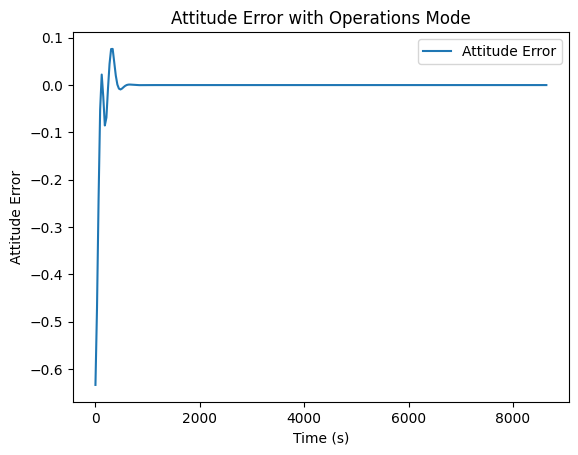

In [11]:
df_att_error = simulation.query_dataframe(computer.get_message("Out_AttitudeErrorMsg"))

fig, ax = plt.subplots()
ax.plot(df_att_error.loc[:, "Time"], df_att_error.loc[:, "Sigma_BR_0"], label="Attitude Error")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Attitude Error")
ax.set_title("Attitude Error with Operations Mode")
ax.legend()

#### Plot the satellite orbit

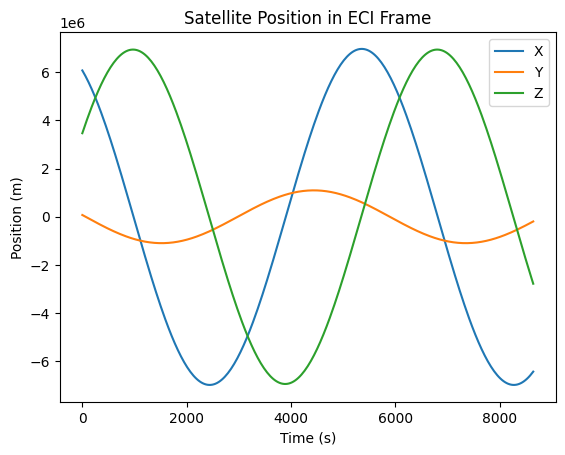

In [12]:
df_sc_state = simulation.query_dataframe(spacecraft.get_message("Out_SpacecraftStateMsg"))

fig, ax = plt.subplots()
ax.plot(df_sc_state.loc[:, "Time"], df_sc_state.loc[:, "Position_BN_N_0"], label="X")
ax.plot(df_sc_state.loc[:, "Time"], df_sc_state.loc[:, "Position_BN_N_1"], label="Y")
ax.plot(df_sc_state.loc[:, "Time"], df_sc_state.loc[:, "Position_BN_N_2"], label="Z")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position (m)")
ax.set_title("Satellite Position in ECI Frame")
ax.legend()